## Проект "Предсказание цен на акции с помощью инструментов машинного обучения"

In [1]:
#!pip install keras

In [2]:
#!pip install tensorflow

In [3]:
#!pip install yfinance

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [5]:
DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    with open(DATA_PATH) as f:
        data = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    data = msft.history(period="max")

    data.to_json(DATA_PATH)

In [6]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,0.055241,0.063365,0.055241,0.060657,1031788800,0.0,0.0
1986-03-14 05:00:00,0.060657,0.063907,0.060657,0.062823,308160000,0.0,0.0
1986-03-17 05:00:00,0.062823,0.064448,0.062823,0.063907,133171200,0.0,0.0
1986-03-18 05:00:00,0.063906,0.064448,0.061740,0.062281,67766400,0.0,0.0
1986-03-19 05:00:00,0.062281,0.062823,0.060657,0.061198,47894400,0.0,0.0
...,...,...,...,...,...,...,...
2023-03-09 05:00:00,255.820007,259.559998,251.580002,252.320007,26653400,0.0,0.0
2023-03-10 05:00:00,251.080002,252.789993,247.600006,248.589996,28321800,0.0,0.0
2023-03-13 04:00:00,247.399994,257.910004,245.729996,253.919998,33339700,0.0,0.0
2023-03-14 04:00:00,256.750000,261.070007,255.860001,260.790009,33620300,0.0,0.0


## Normalize data

In [7]:
data.reset_index(inplace=True)
data = data.rename(columns = {'index':'Date'}) 
data = data.drop(columns=['Volume', 'Open'])

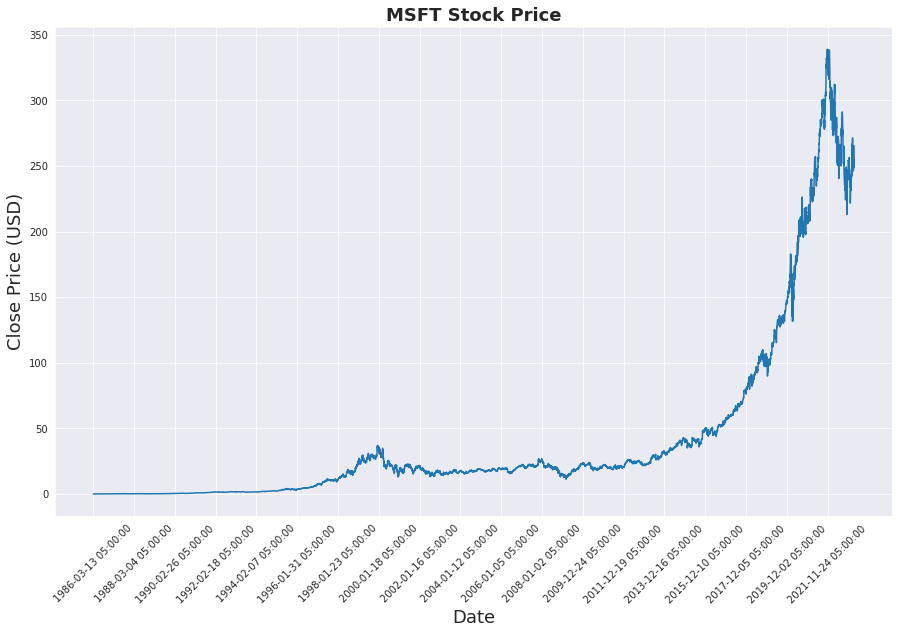

In [8]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("MSFT Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show() 

In [9]:
data = data.drop(['Dividends', 'Stock Splits'], axis=1)

In [10]:
data = data[data['Date']>'2010-01-03 05:00:00']

In [11]:
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data['Weekday'] = data['Date'].dt.weekday+1
data['Month'] = data['Date'].dt.month

In [12]:
data.isna().sum()

Date       0
High       0
Low        0
Close      0
Weekday    0
Month      0
dtype: int64

In [13]:
data.shape[0]

3322

In [14]:
lag = 30
for i in range(20, 31):
    data["lag_{}".format(i)] = data.loc[:,'Close'].shift(i)

In [15]:
#разделим выборку на обучающую и тестовую
#train = data[data['Date']<='2018-01-03 05:00:00']
#test = data[data['Date']>'2018-01-03 05:00:00']

split = 0.8

training_set = data.iloc[:int(split * data.shape[0]), 1:2].values
test_set = data.iloc[int(split * data.shape[0]):, 1:2].values

In [16]:
test_set.shape

(665, 1)

In [17]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, int(split * data.shape[0])):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [18]:
dataset_train = data.iloc[:int(split * data.shape[0]), 1:2]
dataset_test = data.iloc[int(split * data.shape[0]):, 1:2]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
    
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(665, 60, 1)


## LSTM model

In [19]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
82/82 [==============================] - 18s 21ms/step - loss: 0.0053
Epoch 2/100
82/82 [==============================] - 2s 20ms/step - loss: 0.0017
Epoch 3/100
82/82 [==============================] - 1s 14ms/step - loss: 0.0016
Epoch 4/100
82/82 [==============================] - 1s 17ms/step - loss: 0.0012
Epoch 5/100
82/82 [==============================] - 1s 18ms/step - loss: 0.0012
Epoch 6/100
82/82 [==============================] - 1s 13ms/step - loss: 0.0013
Epoch 7/100
82/82 [==============================] - 1s 13ms/step - loss: 0.0012
Epoch 8/100
82/82 [==============================] - 1s 14ms/step - loss: 0.0011
Epoch 9/100
82/82 [==============================] - 1s 13ms/step - loss: 0.0012
Epoch 10/100
82/82 [==============================] - 1s 14ms/step - loss: 0.0010
Epoch 11/100
82/82 [==============================] - 1s 13ms/step - loss: 9.9460e-04
Epoch 12/100
82/82 [==============================] - 1s 14ms/step - loss: 9.7861e-04
Epoch 13/100
82/

In [20]:
print(X_test.shape)

(665, 60, 1)


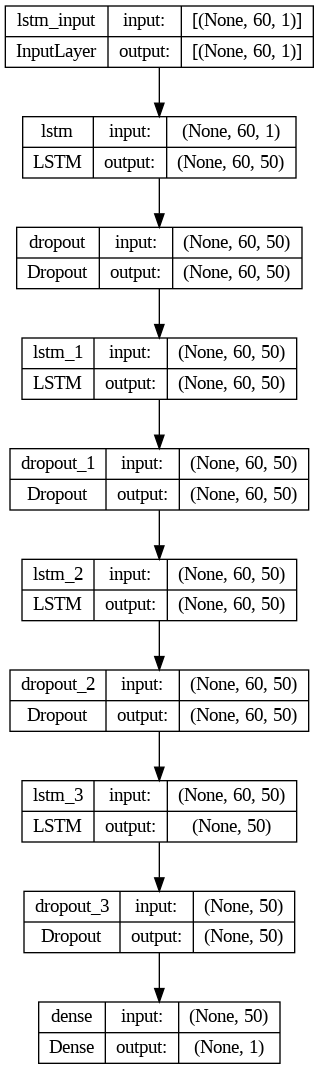

In [21]:
from tensorflow.keras.utils import  plot_model

plot_model(model, to_file='LSTM_model.png', show_shapes=True)

In [22]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
dataset_test.values.shape, predicted_stock_price.shape

21/21 [==============================] - 1s 8ms/step


((665, 1), (665, 1))

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [24]:
print("MSE = %.4f" % mean_squared_error(dataset_test.values, predicted_stock_price))
print("MAE = %.4f" % mean_absolute_error(dataset_test.values, predicted_stock_price))
print("R2 = %.4f" % r2_score(dataset_test.values, predicted_stock_price))

MSE = 1302.5389
MAE = 25.2637
R2 = 0.0027


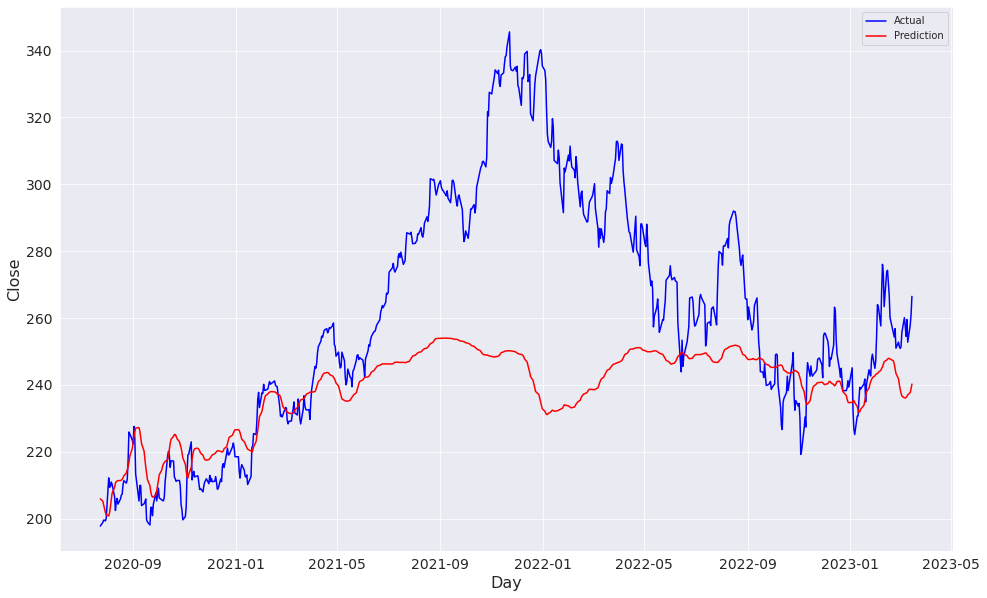

In [25]:
plt.figure(figsize=(16,10))
plt.plot(data.iloc[int(split * data.shape[0]):].Date, dataset_test.values, color = 'blue', label = 'Actual')
plt.plot(data.iloc[int(split * data.shape[0]):].Date, predicted_stock_price, color = 'red', label = 'Prediction')
plt.xlabel('Day', fontsize=16)
plt.ylabel('Close', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.show()

## GRU model

In [27]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

In [29]:
from tensorflow.keras.optimizers import SGD

In [32]:
# compiling the model

regressorGRU.compile(optimizer='adam', loss='mean_squared_error')

# fitting the model

regressorGRU.fit(X_train, y_train, epochs=100, batch_size=150)

Epoch 1/100
18/18 [==============================] - 7s 19ms/step - loss: 0.0183
Epoch 2/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0028
Epoch 3/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0018
Epoch 4/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0016
Epoch 5/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0015
Epoch 6/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0014
Epoch 7/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0012
Epoch 8/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0013
Epoch 9/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0011
Epoch 10/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0011
Epoch 11/100
18/18 [==============================] - 0s 18ms/step - loss: 0.0010
Epoch 12/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0011
Epoch 13/100
18/18 [=====

In [33]:
predicted_with_gru = regressorGRU.predict(X_test)
predicted_with_gru = sc.inverse_transform(predicted_with_gru)

21/21 [==============================] - 2s 6ms/step


In [35]:
print("MSE = %.4f" % mean_squared_error(dataset_test.values, predicted_with_gru))
print("MAE = %.4f" % mean_absolute_error(dataset_test.values, predicted_with_gru))
print("R2 = %.4f" % r2_score(dataset_test.values, predicted_with_gru))

MSE = 138.4533
MAE = 9.2065
R2 = 0.8940


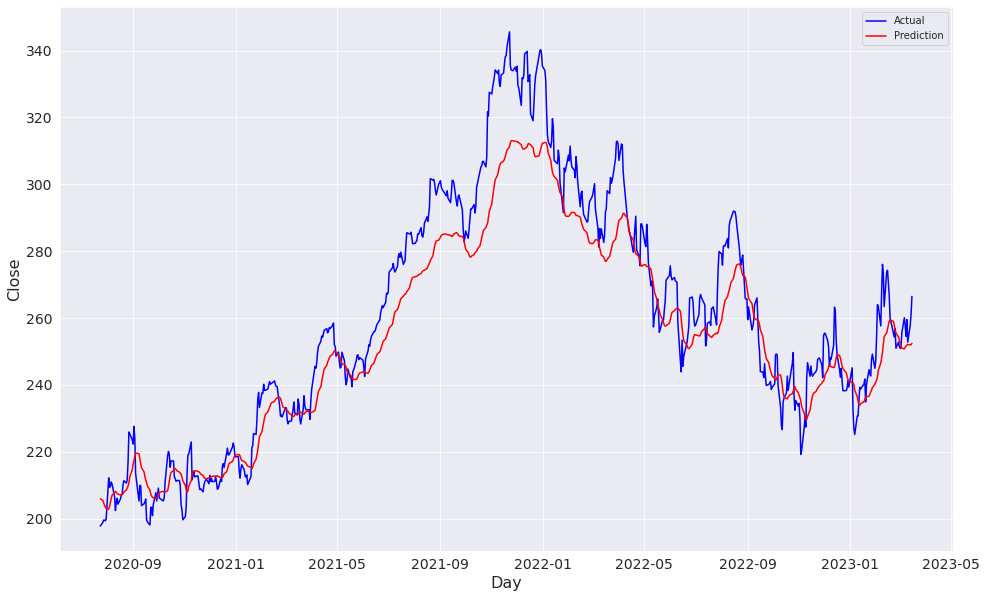

In [36]:
plt.figure(figsize=(16,10))
plt.plot(data.iloc[int(split * data.shape[0]):].Date, dataset_test.values, color = 'blue', label = 'Actual')
plt.plot(data.iloc[int(split * data.shape[0]):].Date, predicted_with_gru, color = 'red', label = 'Prediction')
plt.xlabel('Day', fontsize=16)
plt.ylabel('Close', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.show()